In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## 1. 获取数据

In [2]:
from pathlib import Path

train = pd.read_csv(Path.cwd() / 'input' / 'application_train.csv')
test = pd.read_csv(Path.cwd() / 'input' / 'application_test.csv')

In [143]:
sub = pd.read_csv(Path.cwd() / 'input' / 'sample_submission.csv')

### 1.1 划分训练集和测试集

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(train, test_size=0.1, random_state=42)
train_set.reset_index(inplace=True, drop=True)
test_set.reset_index(inplace=True, drop=True)

## 2. 数据预处理

**处理过程**

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder, Imputer
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.stats import mode

除了target和id，特征可分为以下几组

* 申请人基础信息 x14
* 申请人的借贷信息 x3
* 申请人和当前申请相关的数据 x20
* 申请人的居住环境信息 x50
    * Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
* 过去30天或60天的社会关系 x4
* 客户是否提供了文件X x20
* 申请前在Credit Bureau的查询次数 x6
* 其他数据源 x3

**total = 120**


In [5]:
# ID和target
base = ['SK_ID_CURR', 'TARGET']
# 用户信息
info_cols = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
    'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'OWN_CAR_AGE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE'
    ]
# 当前申请的基础信息
loan_cols = ['NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'AMT_ANNUITY']
# 当前申请相关信息
app_cols = [
    'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
    'NAME_TYPE_SUITE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'WEEKDAY_APPR_PROCESS_START',
    'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY', 'DAYS_LAST_PHONE_CHANGE'
    ]
# 申请人居住环境信息
live_cols = [
    'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
    'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
    'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
    'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
    'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
    ]
# Social Surroundings
social_cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
# 是否提交了文件X
doc_cols = [
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
    ]
# Credit Bureau查询数据
bureau_cols = [
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
    ]
# 其他数据源
ext_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [6]:
# 辅助函数
def find_most_common(df, cat_col):
    '''查找DataFrame中指定列的最频繁值，一般用于填充缺失值'''
    tmp = df.groupby(cat_col)[cat_col].agg(len)
    tmp.sort_values(ascending=False, inplace=True)
    return tmp.index[0]

def get_by_ratio(series, size):
    '''传入一个Series，以数据值的大小为概率返回index'''
    val_dict = {idx: val for idx, val in enumerate(series.index)}
    np.random.seed(1)
    dice = np.random.randint(0, series.sum(), size=size)
    cs = series.cumsum()
    fillvals = pd.Series(
        np.apply_along_axis(
            func1d=lambda x: len(x) - len(x[x]),
            arr=(cs.values - dice[:, None]) > 0,
            axis=1))
    # 返回np.ndarray，排除Series赋值时index的影响
    return fillvals.map(val_dict).values

### 2.1 基础信息

In [81]:
class InfoImputer(BaseEstimator, TransformerMixin):
    '''处理缺失值'''
    def __init__(self, fill_cnt_fam_mem=1, fill_own_car_age=100.0):
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        self.cols = info_cols
        self.fill_cnt_fam_mem = fill_cnt_fam_mem  # {1, 2}
        self.fill_own_car_age = fill_own_car_age  # default: 100

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X[self.cols].copy()
        # 1. 处理缺失值和异常值
        # 1.1 OCCUPATION_TYPE
        X['OCCUPATION_TYPE'].fillna('NA staff', inplace=True)
        # 1.2 CNT_FAM_MEMBERS
        X['CNT_FAM_MEMBERS'].fillna(self.fill_cnt_fam_mem, inplace=True)
        # 1.3 OWN_CAR_AGE
        X.loc[
            (X['OWN_CAR_AGE'].isnull()) & (X['FLAG_OWN_CAR']=='N'),
            'OWN_CAR_AGE'] = self.fill_own_car_age
        X.loc[
        (X['OWN_CAR_AGE'].isnull()) & (X['FLAG_OWN_CAR']=='Y'),
        'OWN_CAR_AGE'] = X['OWN_CAR_AGE'].mean()
        self.feats = X.columns
        return X


class CatTransformer(BaseEstimator, TransformerMixin):
    '''处理离散值转换'''
    def __init__(self, columns):
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        self.cols = columns

    def fit(self, X, y=None):
        self.encoders = {}
        for c in X.columns[X.dtypes=='O']:
            self.encoders[c] = LabelEncoder().fit(X[c])
        return self

    def transform(self, X, y=None):
        # 2. 编码
        for c in X.columns[X.dtypes=='O']:
            X[c] = self.encoders[c].fit_transform(X[c])
        return X


### 2.2 借贷信息

In [82]:
class LoanImputer(BaseEstimator, TransformerMixin):
    '''处理缺失值'''
    def __init__(self):
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        self.cols = loan_cols

    def fit(self, X, y=None):
        self.amt_annuity_mean = X['AMT_ANNUITY'].mean()
        return self

    def transform(self, X, y=None):
        X = X[self.cols].copy()
        # 1. 处理缺失值和异常值
        # 1.1 AMT_ANNUITY
        X['AMT_ANNUITY'].fillna(self.amt_annuity_mean, inplace=True)
        self.feats = X.columns
        return X

### 2.3 申请信息

In [83]:
class AppImputer(BaseEstimator, TransformerMixin):
    '''处理缺失值'''
    def __init__(self):
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        self.cols = app_cols

    def fit(self, X, y=None):
        self.name_type_suite_mode = find_most_common(X, 'NAME_TYPE_SUITE')
        self.days_last_phone_change_mean = X['DAYS_LAST_PHONE_CHANGE'].mean()
        self.amt_goods_price_mean = X['AMT_GOODS_PRICE'].mean()
        return self

    def transform(self, X, y=None):
        X = X[self.cols].copy()
        # 1. 处理缺失值和异常值
        X['NAME_TYPE_SUITE'].fillna(self.name_type_suite_mode, inplace=True)
        X['DAYS_LAST_PHONE_CHANGE'].fillna(self.days_last_phone_change_mean, inplace=True)
        X['AMT_GOODS_PRICE'].fillna(self.amt_goods_price_mean, inplace=True)
        self.feats = X.columns
        return X

### 2.4 居住信息

In [84]:
class LiveImputer(BaseEstimator, TransformerMixin):
    '''处理缺失值'''
    def __init__(self, threshold=0.5):
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        self.cols = live_cols
        self.threshold = threshold
        
    def fit(self, X, y=None):
        self.num_miss_rates = {}
        self.num_cols_mean = {}
        for c in live_cols:
            if X[c].dtype != 'O':
                self.num_miss_rates[c] = X[c].isnull().sum() / X.shape[0]
                self.num_cols_mean[c] = X[c].mean()
        return self

    def transform(self, X, y=None):
        X = X[self.cols].copy()
        # 1. 处理缺失值和异常值
        # 1.1 处理数值型特征
        ret_feats = []
        for col, rate in self.num_miss_rates.items():
            if rate < self.threshold:
                ret_feats.append(col)
        for col in ret_feats:
            X[col].fillna(self.num_cols_mean[col], inplace=True)
        # 1.2 处理离散特征
        cat_feats = [c for c in live_cols if X[c].dtype=='O']
        for col in cat_feats:
            X[col].fillna('NA', inplace=True)
        X = X[ret_feats + cat_feats]
        self.feats = X.columns
        return X

### 2.5 社交信息

In [85]:
class SocialImputer(BaseEstimator, TransformerMixin):
    '''处理缺失值'''
    def __init__(self, fill_social_na=0, threshold=10):
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        self.cols = social_cols
        self.fill_social_na = fill_social_na
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X[self.cols].copy()
        # 1. 处理缺失值和异常值
        # 1.1 处理数值型特征
        X.fillna(self.fill_social_na, inplace=True)

        # 2. 转化离群点
        X.loc[
            X['OBS_30_CNT_SOCIAL_CIRCLE'] > self.threshold,
            'OBS_30_CNT_SOCIAL_CIRCLE'] = self.threshold
        X.loc[
            X['OBS_60_CNT_SOCIAL_CIRCLE'] > self.threshold,
            'OBS_60_CNT_SOCIAL_CIRCLE'] = self.threshold
        self.feats = X.columns
        return X

### 2.6 提交文件信息

In [86]:
# 没有缺失值，且不需要编码
class DocImputer(BaseEstimator, TransformerMixin):
    '''处理缺失值'''
    def __init__(self):
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        self.cols = doc_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X[self.cols].copy()
        self.feats = X.columns
        return X


### 2.7 Bureau查询数据

In [87]:
# 方法1：全都填充为0
# 方法2：按比例填充, 注意设置随机种子
class BureauImputer(BaseEstimator, TransformerMixin):
    '''处理缺失值'''
    def __init__(self, method='zero'):
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        self.cols = bureau_cols
        self.method = method  # {'zero', 'ratio'}

    def fit(self, X, y=None):
        self.value_counts = {}
        for c in self.cols:
            self.value_counts[c] = X[c].value_counts()
        return self

    def transform(self, X, y=None):
        X = X[self.cols].copy()
        # 1. 处理缺失值和异常值
        if self.method == 'zero':
            for c in X.columns[X.isnull().any(axis=0)==True]:
                X[c].fillna(0, inplace=True)
        elif self.method == 'ratio':
            for c in X.columns[X.isnull().any(axis=0)==True]:
                X.loc[X[c].isnull(), c] = get_by_ratio(
                    self.value_counts[c], X[c].isnull().sum())
        else:
            raise ValueError("Wrong method.")
        self.feats = X.columns
        return X

### 2.8 其他数据源

In [88]:
# 方法1：全都填充为0
# 方法2：按比例填充, 注意设置随机种子
class ExtImputer(BaseEstimator, TransformerMixin):
    '''处理缺失值'''
    def __init__(self):
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        self.cols = ext_cols

    def fit(self, X, y=None):
        self.means = {}
        for c in self.cols:
            self.means[c] = X[c].mean()
        return self

    def transform(self, X, y=None):
        X = X[self.cols].copy()
        # 1. 处理缺失值和异常值
        for c in X.columns[X.isnull().any(axis=0)==True]:
            X[c].fillna(self.means[c], inplace=True)
        self.feats = X.columns
        return X

### ALL in One

In [89]:
pre_pipe = FeatureUnion(
    transformer_list=[
        ('info', Pipeline([
                ('impute', InfoImputer()),
                ('transform', CatTransformer(info_cols))
            ])),
        ('loan', Pipeline([
            ('impute', LoanImputer()),
            ('transform', CatTransformer(loan_cols))
            ])),
        ('app', Pipeline([
            ('impute', AppImputer()),
            ('transform', CatTransformer(app_cols))
            ])),
        ('live', Pipeline([
            ('impute', LiveImputer()),
            ('transform', CatTransformer(live_cols))
            ])),
        ('social', SocialImputer()),
        ('doc', DocImputer()),
        ('bureau', BureauImputer()),
        ('ext', ExtImputer())
    ])

## 3. 训练

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier

In [90]:
# 模型
lgbm = LGBMClassifier(
    n_estimators=250,
    objective='binary'
    )
pipe = Pipeline([
    ('preprocessing', pre_pipe),
    ('clf', lgbm)])

In [42]:
X = train_set.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target = train_set['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.1, random_state=2)

In [91]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessing', FeatureUnion(n_jobs=1,
       transformer_list=[('info', Pipeline(memory=None,
     steps=[('impute', InfoImputer(fill_cnt_fam_mem=1, fill_own_car_age=100.0)), ('transform', CatTransformer(columns=None))])), ('loan', Pipeline(memory=None,
     steps=[('impute', LoanImputer()...da=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1))])

In [44]:
print("训练acc", accuracy_score(pipe.predict(X_train), y_train))
print("验证acc", accuracy_score(pipe.predict(X_test), y_test))
print("训练AUC", roc_auc_score(y_train, pipe.predict_proba(X_train)[:, 1]))
print("验证AUC", roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]))

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


训练acc 0.9218212403094551


E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


验证acc 0.9197138314785374
训练AUC 0.82709648520703
验证AUC 0.7568576064885845


### 3.2 特征重要性

In [100]:
feats = []
for item in pipe.get_params()['preprocessing__transformer_list']:
    if isinstance(item[1], Pipeline):
        feats = feats + item[1].get_params()['impute'].feats.tolist()
    else:
        feats = feats + item[1].feats.tolist()

In [117]:
feats_imp = pd.DataFrame({
    'feat': feats,
    'score': pipe.named_steps['clf'].feature_importances_
    })
feats_imp.sort_values(by='score', ascending=False, inplace=True)

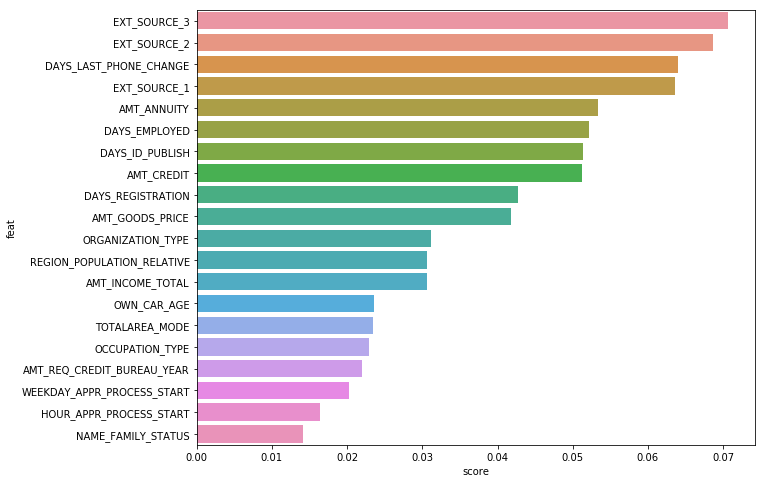

In [122]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='score', y='feat', data=feats_imp.iloc[:20])

## 4. 提交

In [176]:
pred = pipe.predict_proba(test)[:, 1]

In [177]:
sub = pd.DataFrame({
    'SK_ID_CURR': test.SK_ID_CURR,
    'TARGET': pred})

In [178]:
sub_path = Path.cwd() / 'sub' / '20180804-1.csv'
sub.to_csv(sub_path, index=False)